In [152]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

folder = 'data/week3/'

In [216]:
# Trading game Data:
xls_dict  = pd.read_excel(folder + 'trading-game-data-15112023.xlsx', sheet_name=None)

info_df = xls_dict['info'][['Ticker', 'RBICS Economy']]
info_df = info_df.set_index('Ticker')

index_price_df = xls_dict['index-price']
index_price_df['Date'] = pd.to_datetime(index_price_df['Date'])
index_price_df.set_index('Date', inplace=True)

price_df = xls_dict['price']
size_df = xls_dict['size']
price_to_book_df = xls_dict['price-to-book']
turnover_df = xls_dict['turnover']

price_df = xls_dict['price'].reset_index()
price_df = price_df.drop('index', axis = 1)
price_df['Date'] = pd.to_datetime(price_df['Date'])
price_df.set_index('Date', inplace=True)

In [158]:
# ESG data: 
def get_esgdata(esgratings_df, info_df):
    esgratings_df = esgratings_df[['Symbol', 'Sector', 'Total ESG Risk score']]
    sector_medians = esgratings_df.groupby('Sector')['Total ESG Risk score'].median()

    # Create a DataFrame with the ESG scores
    full_esg_df = pd.DataFrame(index=info_df.index)
    full_esg_df['ESG Score'] = np.nan  # Initialize all scores as NaN

    # Iterate over all companies in info_df
    for company in full_esg_df.index:
        if company in esgratings_df['Symbol'].values:
            # Use the actual ESG score if available
            full_esg_df.at[company, 'ESG Score'] = esgratings_df[esgratings_df['Symbol'] == company]['Total ESG Risk score'].values[0]
        else:
            # Retrieve the sector from info_df
            sector = info_df.at[company, 'RBICS Economy']
            # Use the sector median if the sector is available
            if sector in sector_medians.index:
                full_esg_df.at[company, 'ESG Score'] = sector_medians[sector]

    # Handling cases where the sector is unknown or no median is available
    full_esg_df['ESG Score'].fillna(full_esg_df['ESG Score'].median(), inplace=True)
    full_esg_df['Inverted_ESG'] = -full_esg_df['ESG Score']
    
    return full_esg_df

esgratings_df = get_esgdata(pd.read_csv(folder + 'esg data.csv'), info_df)

In [135]:
# FF model:
momentum_df = pd.read_csv(folder + 'F-F_Momentum_Factor_daily.CSV')
factors_df = pd.read_csv(folder + 'F-F_5factors_daily.CSV')

momentum_df.columns = ['Date', 'Momentum']
factors_df.columns = ['Date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
factors_df = factors_df.merge(momentum_df, on='Date')
factors_df = factors_df.rename(columns={"Unnamed: 0": "Date"})
factors_df['Date'] = pd.to_datetime(factors_df['Date'], format='%Y%m%d')
factors_df.set_index('Date', inplace=True)
factors_df.to_parquet('ff_momentum.par')

In [212]:
def calcualte_logreturns(price_df):
    # Assuming price_df is indexed by date and contains end-of-day prices
    daily_returns = np.log(price_df / price_df.shift(1))
    return daily_returns

log_returns = calcualte_logreturns(price_df)

In [289]:
sentiment_index = pd.read_excel(folder + "michigan_sentimentindex.xlsx", sheet_name='Sheet1')
sentiment_index['Date'] = pd.to_datetime(sentiment_index['Date'], format='%Y-%m-%d')
sentiment_index['Sentiment Index']  = sentiment_index['Index']
sentiment_index = sentiment_index.drop('Index', axis = 1) 
sentiment_index.set_index('Date', inplace=True)

## Stock analysis:

In [110]:
# sentiment_index (1 november 2023)
# esgratings_df['Inverted_ESG'] (scaling factor)
# factors_df (daily till 29 september 2023)
# info_df (economy specific infromation (categrization))

# index_price_df (sp500 index value till 30/12/2023 -14/11/2023)
# price_df (stock price  30/12/2023 -14/11/2023)
## log_returns 

# size_df (size (volume))
# price_to_book_df
# turnover_df

In [219]:
sentiment_index

,Index
Date,
2008-01-01,78.4
2008-02-01,70.8
2008-03-01,69.5
2008-04-01,62.6
2008-05-01,59.8
...,...
2023-07-01,71.5
2023-08-01,69.4
2023-09-01,67.9


In [217]:
def calcualte_logreturns(price_df):
    # Assuming price_df is indexed by date and contains end-of-day prices
    daily_returns = np.log(price_df / price_df.shift(1))
    return daily_returns
log_indexprice = calcualte_logreturns(index_price_df)

In [227]:
filtered_sentiment_index

,Index
Date,
2023-01-01,64.9
2023-02-01,66.9
2023-03-01,62
2023-04-01,63.7
2023-05-01,59
2023-06-01,64.2
2023-07-01,71.5
2023-08-01,69.4
2023-09-01,67.9


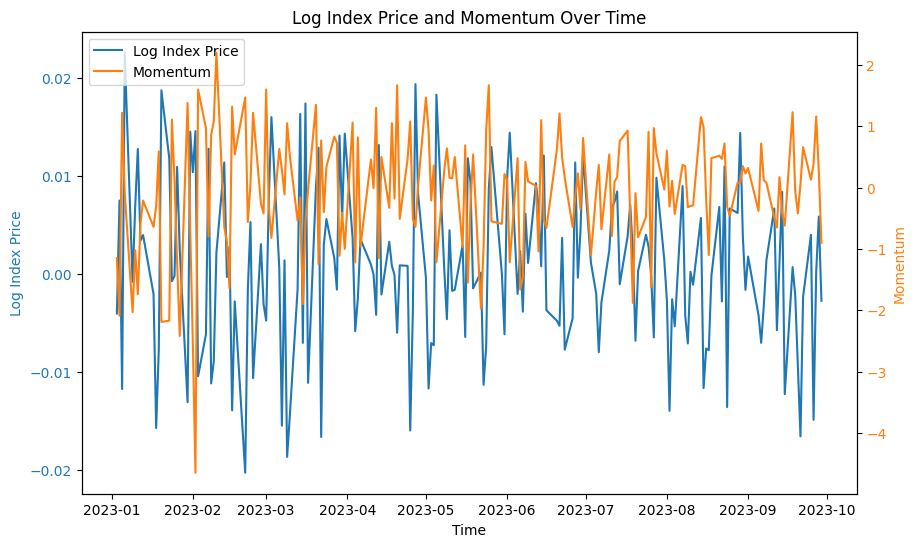

In [229]:
start_date = '2022-12-31'
end_date = '2023-09-29'


# Extract the relevant columns
momentum = factors_df['Momentum']
sentiment_index = sentiment_index
log_indexprice = log_indexprice

# Filter the data based on start_date and end_date
filtered_momentum = momentum[(momentum.index >= start_date) & (momentum.index <= end_date)]
filtered_sentiment_index = sentiment_index[(sentiment_index.index >= start_date) & (sentiment_index.index <= end_date)]
filtered_log_indexprice = log_indexprice[(log_indexprice.index >= start_date) & (log_indexprice.index <= end_date)]

# Create two subplots, one for Log Index Price and Momentum, and the other for Log Index Price and Sentiment Index
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Log Index Price and Momentum on the left side axis (ax1)
ax1.plot(filtered_log_indexprice, label='Log Index Price', color='tab:blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('Log Index Price', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis on the right side for Sentiment Index
ax2 = ax1.twinx()  # Share the same x-axis
ax2.plot(filtered_momentum, label='Momentum', color='tab:orange')
ax2.set_ylabel('Momentum', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Add a legend for both lines
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, loc='upper left')

plt.title('Log Index Price and Momentum Over Time')
plt.show()
plt.show()

In [208]:
factors_df.columns

Index(['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'Momentum'], dtype='object')

In [140]:
start_date = '2022-12-31'
end_date = '2023-09-29'

factors_df_filtered = factors_df[(factors_df.index >= start_date )& (factors_df.index <= end_date)]
daily_returns = log_returns[(log_returns.index >= start_date ) & (log_returns.index <= end_date)]
sentiment_index_filtered = sentiment_index[(sentiment_index.index >= start_date ) & (sentiment_index.index <= end_date)]

1. Mkt-RF  (50/50)
2. CMA ()
- 

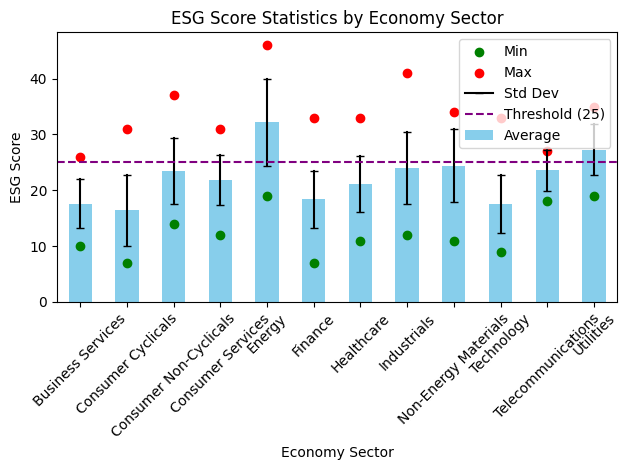

After using threshold for esg ratings (25), we are still left with 376 companies


In [176]:
def plot_ESGscore_candlechart(esgratings_df, info_df, threshold):
    merged_df = pd.merge(info_df, esgratings_df, on='Ticker')
    # Calculating statistics
    stats_df = merged_df.groupby('RBICS Economy')['ESG Score'].agg(['mean', 'min', 'max', 'std'])
    fig, ax = plt.subplots()

    # Bar plot for the mean
    stats_df['mean'].plot(kind='bar', ax=ax, color='skyblue', label='Average')

    # Scatter plot for min and max
    ax.scatter(stats_df.index, stats_df['min'], color='green', label='Min')
    ax.scatter(stats_df.index, stats_df['max'], color='red', label='Max')

    # Plot lines for standard deviation
    for sector in stats_df.index:
        mean = stats_df.at[sector, 'mean']
        std_dev = stats_df.at[sector, 'std']
        ax.plot([sector, sector], [mean - std_dev, mean + std_dev], color='black', marker='_', label='Std Dev' if sector == stats_df.index[0] else "")

    # Adding a horizontal line for the threshold
    ax.axhline(y=threshold, color='purple', linestyle='--', label='Threshold (25)')
    plt.title('ESG Score Statistics by Economy Sector')
    plt.xlabel('Economy Sector')
    plt.ylabel('ESG Score')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

def filter_esgratings(esg_ratings, threshold = 25):
    filtered_esgcompanies = esg_ratings[esg_ratings['ESG Score'] <= threshold]
    print(f'After using threshold for esg ratings ({threshold}), we are still left with {len(filtered_esgcompanies)} companies')
    return filtered_esgcompanies.index


threshold = 25
plot_ESGscore_candlechart(esgratings_df, info_df, threshold)
filtered_esgcompanies = filter_esgratings(esgratings_df, threshold = 25)

In [291]:
start_date = '2022-12-31'
end_date = '2023-09-29'

factors_df_filtered = factors_df[(factors_df.index >= start_date )& (factors_df.index <= end_date)]
daily_returns = log_returns[(log_returns.index >= start_date ) & (log_returns.index <= end_date)]
sentiment_index_filtered = sentiment_index[(sentiment_index.index >= start_date ) & (sentiment_index.index <= end_date)]

In [295]:
sentiment_index.index

DatetimeIndex(['2008-01-01', '2008-02-01', '2008-03-01', '2008-04-01',
               '2008-05-01', '2008-06-01', '2008-07-01', '2008-08-01',
               '2008-09-01', '2008-10-01',
               ...
               '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01',
               '2023-06-01', '2023-07-01', '2023-08-01', '2023-09-01',
               '2023-10-01', '2023-11-01'],
              dtype='datetime64[ns]', name='Date', length=191, freq=None)

In [312]:
factors_df.columns

Index(['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'Momentum'], dtype='object')

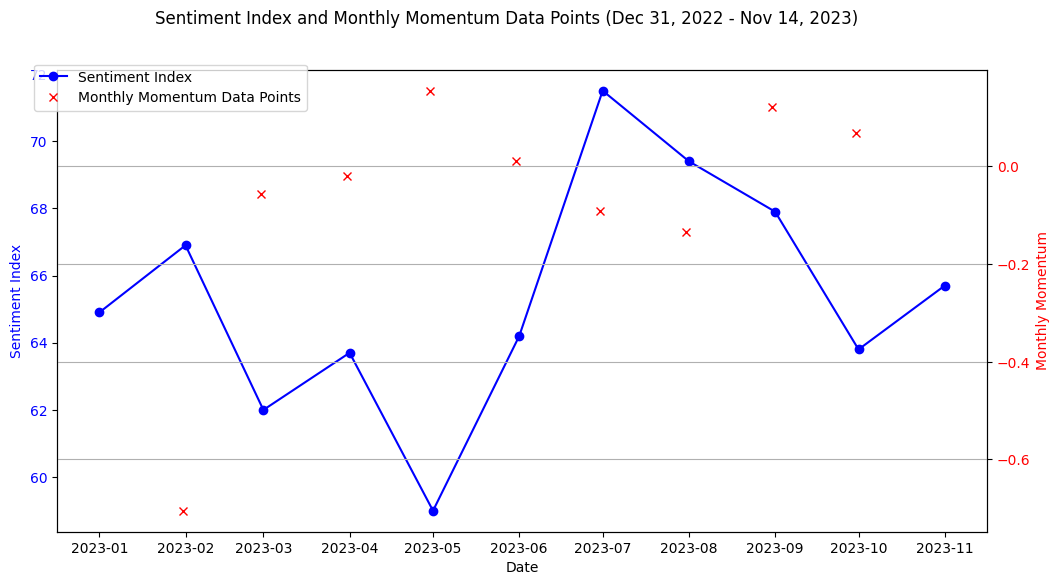

In [320]:
# Create the plot
sentiment_index['Sentiment Index'] = sentiment_index['Sentiment Index'].astype(float)
monthly_momentum = factors_df['Momentum'][start_date:end_date].resample('M').mean()

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot 'Sentiment Index' on the left y-axis
ax1.plot(sentiment_index[start_date:end_date].index, sentiment_index[start_date:end_date]['Sentiment Index'], marker='o', color='blue', linestyle='-', label='Sentiment Index')
ax1.set_xlabel('Date')
ax1.set_ylabel('Sentiment Index', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()

ax2.plot(monthly_momentum.index, monthly_momentum, marker='x', color='red', linestyle='', label='Monthly Momentum Data Points')
ax2.set_ylabel('Monthly Momentum', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add a common title and legend
fig.suptitle('Sentiment Index and Monthly Momentum Data Points (Dec 31, 2022 - Nov 14, 2023)')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

plt.grid(True)
plt.show()

In [347]:
def regression_famafrench(daily_returns):
    n = len(daily_returns.columns)

    df_params = pd.DataFrame(index = daily_returns.columns, columns = ['alpha', 'Mkt-RF', 'SMB', 'HML',	'RMW', 'CMA', 'RF', 'Momentum'])
    df_signif = pd.DataFrame(index = daily_returns.columns, columns = ['alpha', 'Mkt-RF', 'SMB', 'HML',	'RMW', 'CMA', 'RF', 'Momentum'])

    for i in range(0, len(daily_returns.columns)):
        #regress the daily returns of the first stock on the factors and ESG score
        y = daily_returns.iloc[:,i]
        x = np.column_stack((factors_df_filtered['Mkt-RF'], factors_df_filtered['SMB'], factors_df_filtered['HML'], factors_df_filtered['RMW'], factors_df_filtered['CMA'], factors_df_filtered['RF'], factors_df_filtered['Momentum']))
        x = sm.add_constant(x)
        model = sm.OLS(y,x)
        results = model.fit()

        for j in range(0, len(df_params.columns)):
            df_params.iloc[i, j] = results.params[j]
        #get the t-values
        for j in range(0, len(df_signif.columns)):
            df_signif.iloc[i, j] = results.tvalues[j]

    return df_params, df_signif

filtered_esgcompanies = filter_esgratings(esgratings_df, threshold = 25)
df_params, df_signif = regression_famafrench(daily_returns[filtered_esgcompanies])

After using threshold for esg ratings (25), we are still left with 376 companies


In [385]:
variable = "Mkt-RF"

significant_stocks = df_signif[df_signif[variable] > 1.96].index

# Calculate the lower and upper quantiles for the selected stocks based on the 'variable'
threshold_mkt_rf_L = df_params.loc[significant_stocks, variable].quantile(0.25)
threshold_mkt_rf_U = df_params.loc[significant_stocks, variable].quantile(0.75)

# Filter the 'df_params' DataFrame for the selected stocks based on the 'variable' and the correct thresholds
df_params_signf = df_params.loc[significant_stocks]

# Select stocks where the 'variable' is within the range defined by the quantiles
selected_stocks = df_params_signf[(df_params_signf[variable] >= threshold_mkt_rf_L) & (df_params_signf[variable] <= threshold_mkt_rf_U)]


In [384]:
selected_stocks

,alpha,Mkt-RF,SMB,HML,RMW,CMA,RF,Momentum
A,-0.014425,0.009156,0.000182,-0.001607,0.000064,0.007231,0.680362,-0.004031
ABT,-0.007993,0.009444,-0.00263,-0.005299,-0.002598,0.015379,0.405447,-0.002583
ACGL,-0.002085,0.010127,-0.000292,0.003625,-0.004342,0.004274,0.223593,0.006467
ACN,0.003521,0.009169,0.002479,-0.001605,0.003461,-0.003166,-0.202526,-0.000744
ADI,-0.002924,0.010923,0.004143,-0.003624,-0.000467,-0.001574,0.13388,0.000975
...,...,...,...,...,...,...,...,...
WTW,0.004652,0.00859,0.00175,-0.000707,-0.000842,0.008549,-0.27735,0.000483
WY,-0.003959,0.009651,0.005684,-0.001658,-0.000512,0.003912,0.201811,-0.001017
XRAY,-0.003494,0.010491,0.001506,-0.004539,-0.002189,0.011045,0.19943,-0.004509
YUM,-0.000616,0.009051,-0.002033,-0.002481,-0.001314,0.010133,0.038984,0.0011
